**Import**

In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model
import time
import matplotlib.pyplot as plt

**Load DataSet**

In [0]:
# Load MNIST Dataset
dataset, info = tfds.load('mnist', as_supervised = True, with_info = True)
dataset_test, dataset_train = dataset['test'], dataset['train']

#Convert
def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 128

dataset_train = dataset_train.map(convert_types).shuffle(10000).batch(batch_size)
dataset_test = dataset_test.map(convert_types).batch(batch_size)
#Data Augmentation
datagen = ImageDataGenerator(rotation_range = 10, horizontal_flip = True, zoom_range = 0.1)

**ResNet50 Model**

In [9]:
# Residual Block
class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()
      
        channel = channel_out // 4
        # Batch Normalization after Concolution layer
        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)
        
    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y
    
    # Shortcut
    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)
        
    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")

# ResNet           
class ResNet50(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()                
        
        self._layers = [
            # convolution Layer 1 (conv1)
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu),
            # convolution Layer 2 (conv2_x)
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(2)                
            ],
            # convolution Layer 3 (conv3_x)
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(512, 512) for _ in range(4)                
            ],
            # convolution Layer 4 (conv4_x)
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(1024, 1024) for _ in range(6)                
            ],
            # convolution Layer 5 (conv5_x)
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(2048, 2048) for _ in range(3)
            ],
            # Average Pooling and FC1000 layer
            GlobalAveragePooling2D(),
            Dense(1000, activation = tf.nn.relu),
            Dense(output_dim, activation = tf.nn.softmax)
        ]
        
    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)    
            else:
                x = layer(x)
        return x
       
model = ResNet50((28, 28, 1), 10)
model.build(input_shape = (None, 28, 28, 1))
model.summary()

Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           multiple                  3200      
_________________________________________________________________
batch_normalization_49 (Batc multiple                  256       
_________________________________________________________________
activation_49 (Activation)   multiple                  0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
residual_block_16 (ResidualB multiple                  75904     
_________________________________________________________________
residual_block_17 (ResidualB multiple                  71552     
_________________________________________________________________
residual_block_18 (ResidualB multiple                  71

**Loss and OPtimizer**

In [0]:
# Categorial CrossEntropy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
# Adam
optimizer = tf.keras.optimizers.Adam()

**Pre-Training**

In [0]:
# Train Loss and Accuracy
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')
# Test Loss and Accuracy
test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')


@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model(image)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(label, predictions)
        
@tf.function
def test_step(image, label):
    predictions = model(image)
    loss = loss_object(label, predictions)
    
    test_loss(loss)
    test_accuracy(label, predictions)


**Training**

In [12]:
num_epoch = 50
start_time = time.time()

train_accuracies = []
test_accuracies = []

for epoch in range(num_epoch):    
    for image, label in dataset_train:
        for _image, _label in datagen.flow(image, label, batch_size = batch_size):
            train_step(_image, _label)
            break
        
    for test_image, test_label in dataset_test:
        test_step(test_image, test_label)
        
    train_accuracies.append(train_accuracy.result())
    test_accuracies.append(test_accuracy.result())    
    
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, spent_time: {} min'
    spent_time = time.time() - start_time
    print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100, test_loss.result(), test_accuracy.result() * 100, spent_time / 60))


Epoch 1, Loss: 0.6807350516319275, Accuracy: 75.73833465576172, Test Loss: 0.17914921045303345, Test Accuracy: 94.76000213623047, spent_time: 0.8261510252952575 min
Epoch 2, Loss: 0.4209822118282318, Accuracy: 85.50833129882812, Test Loss: 0.14059126377105713, Test Accuracy: 95.79499816894531, spent_time: 1.4815698663393657 min
Epoch 3, Loss: 0.3227335810661316, Accuracy: 89.14888763427734, Test Loss: 0.12302588671445847, Test Accuracy: 96.26000213623047, spent_time: 2.137596619129181 min
Epoch 4, Loss: 0.26930177211761475, Accuracy: 91.08291625976562, Test Loss: 0.111155666410923, Test Accuracy: 96.63999938964844, spent_time: 2.79676558971405 min
Epoch 5, Loss: 0.23468300700187683, Accuracy: 92.31266021728516, Test Loss: 0.1010543704032898, Test Accuracy: 96.9540023803711, spent_time: 3.4631495674451194 min
Epoch 6, Loss: 0.21036475896835327, Accuracy: 93.18305969238281, Test Loss: 0.10000288486480713, Test Accuracy: 97.02666473388672, spent_time: 4.127037608623505 min
Epoch 7, Loss: 

**Plot**

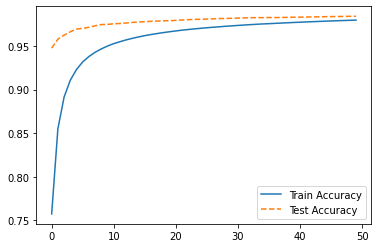

In [13]:
plt.plot(train_accuracies, label = 'Train Accuracy')
plt.plot(test_accuracies, linestyle = 'dashed', label = 'Test Accuracy')
plt.legend()
plt.show()